In [29]:
import numpy as np
from skimage import io
from skimage.color import rgb2gray
from skimage.transform import resize

In [32]:
img = io.imread('https://i.pinimg.com/originals/c4/06/65/c40665c475735cf7436a12b9995998b2.jpg')
img = resize(rgb2gray(img), np.array(img.shape) / 5)[:, :, 0]
img.shape

(360, 576)

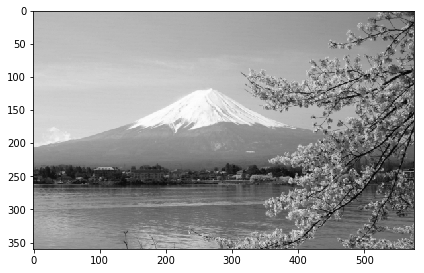

In [33]:
io.imshow(img);

In [34]:
def svd(A):
    ATA = A.T @ A
    

In [35]:
A = img.copy()

In [36]:
ATA = A.T @ A

In [69]:
sigmas_sq, V = np.linalg.eig(ATA)

In [80]:
Sigma = np.diag(sigmas_sq) ** 0.5

In [77]:
np.allclose(V.dot(np.diag(sigmas_sq)).dot(V.T), ATA)

True

In [79]:
U = (A @ V) / (sigmas_sq.reshape(1, -1)**0.5)

In [82]:
np.allclose(A, U @ Sigma @ V.T)

True

In [85]:
VT = V.T

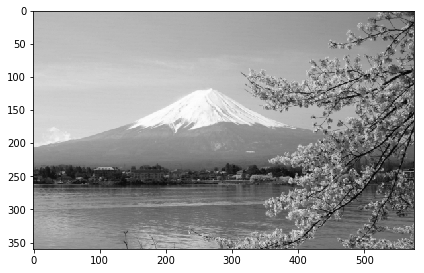

In [95]:
io.imshow(np.real(U @ Sigma @ VT));

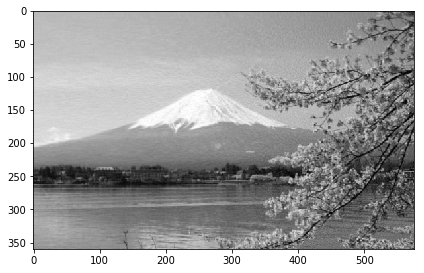

In [116]:
k = 100

img_k_components = np.real(U[:, :k] @ Sigma[:k, :k] @ VT[:k, :])

io.imshow(np.clip(img_k_components, 0, 1))

In [117]:
np.prod(U[:, :k].shape) + k + np.prod(VT[:k, :].shape)

93700

In [118]:
np.prod(A.shape)

207360